In [1]:
import pandas as pd
import numpy as np
import sys
import jsonpickle as jp
import matplotlib.pyplot as plt
import logging
from collections import defaultdict
import jsonpickle


sys.path.append(r"/Users/ysc/Desktop/imcProsperity/utils")

import datamodel
import simulator

pd.options.mode.chained_assignment = None


In [4]:
import datamodel
from datamodel import OrderDepth, UserId, TradingState, Order
import jsonpickle
import numpy as np


DEBUG_MODE = True

class Trader:

    LIMIT = {
        'AMETHYSTS': 20,
        'STARFRUIT': 20,
        "ORCHIDS": 100,
        'CHOCOLATE': 250,
        'STRAWBERRIES': 350,
        'ROSES': 60,
        'GIFT_BASKET': 60
    }
    attributes = {}

    @staticmethod
    def calculate_wavg_midprice(order_depth):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        total_volume = 0
        wavg_price = 0

        for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
        if total_volume == 0:
            return -1
        else:
            return wavg_price / total_volume

    @staticmethod
    def calculate_barrier_price(order_depth, mid, barrier=10):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)

        buy_p_, sell_p_ = -1, -1
        buy_vol_, sell_vol_ = 0, 0
        for p, vol in sorted_buy_orders:
            if p >= mid:
                continue
            if vol >= barrier:
                buy_p_, buy_vol_ = p, vol
                break
            elif vol > buy_vol_:
                buy_p_, buy_vol_ = p, vol
        for p, vol in sorted_sell_orders:
            if p <= mid:
                continue
            vol = abs(vol)
            if vol >= barrier:
                sell_p_, sell_vol_ = p, vol
                break
            elif vol > sell_vol_:
                sell_p_, sell_vol_ = p, vol
        return buy_p_, buy_vol_, sell_p_, sell_vol_

    @staticmethod
    def hit_the_book(product, order_depth, buy_capacity, buy_price, sell_capacity, sell_price):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        orders = []
        for p, vol in sorted_buy_orders:
            vol = abs(vol)
            if p >= sell_price:
                s_amt = min(sell_capacity, vol)
                if s_amt > 0:
                    sell_capacity -= s_amt
                    orders.append(Order(product, p, -s_amt))
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            if p <= buy_price:
                b_amt = min(buy_capacity, vol)
                if b_amt > 0:
                    buy_capacity -= b_amt
                    orders.append(Order(product, p, b_amt))
        return orders, buy_capacity, sell_capacity

    def simulate_lambda_reset(self):
        self.attributes = {}

    def run(self, state):

        if DEBUG_MODE and np.random.uniform(0, 1) >= 0.9:
            self.simulate_lambda_reset()

        result = {}
        idx = state.timestamp // 100
        if idx >= 1 and not self.attributes:
            self.attributes = jsonpickle.decode(state.traderData)
        conversions = 0

        for product in state.order_depths:

            current_position = state.position.get(product, 0)
            order_depth = state.order_depths[product]
            sell_capacity = self.LIMIT[product] + current_position
            buy_capacity = self.LIMIT[product] - current_position
            orders = []

            if product == "AMETHYSTS":

                _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
                                                                         buy_capacity, 9999,
                                                                         sell_capacity, 10001)
                orders.extend(_orders)

                ext_buy_price, ext_buy_volume, ext_sell_price, ext_sell_volume = self.calculate_barrier_price(order_depth, 10000, 1)

                sell_price, buy_price = max(10001, ext_sell_price -1), min(9999, ext_buy_price + 1)
                if sell_capacity > 0:
                    orders.append(Order(product, sell_price, -sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, buy_price, buy_capacity))

                result[product] = orders

            elif product == "STARFRUIT":

                prev_price = self.attributes.get("starfruit_price", None)
                if idx == 0:
                    prev_price = self.calculate_wavg_midprice(order_depth)
                elif idx != 0 and prev_price is None:
                    self.attributes = jsonpickle.decode(state.traderData)
                    prev_price = self.attributes.get("starfruit_price", None)

                ext_buy_price, ext_buy_volume, ext_sell_price, ext_sell_volume \
                    = self.calculate_barrier_price(order_depth, prev_price, 15)

                low = None if ext_buy_volume < 15 else ext_buy_price
                top = None if ext_sell_volume < 15 else ext_sell_price

                if top is None and low is None:
                    cur_price = prev_price
                    if cur_price != int(cur_price):
                        top = int(cur_price + 3.5)
                        low = int(cur_price - 3.5)
                    else:
                        top = int(cur_price + 4)
                        low = int(cur_price - 4)
                elif top is None:
                    cur_price = low + 3.5
                    top = low + 7
                elif low is None:
                    cur_price = top - 3.5
                    low = top - 7
                else:
                    cur_price = (low + top) / 2

                self.attributes['starfruit_price'] = cur_price

                if sell_capacity <= 5:
                    sell_margin, buy_margin = 1, 0.5
                elif buy_capacity <= 5:
                    sell_margin, buy_margin = 0.5, 1
                else:
                    sell_margin, buy_margin = 1, 1
                _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
                                                                         buy_capacity, cur_price - buy_margin,
                                                                         sell_capacity, cur_price + sell_margin)
                orders.extend(_orders)

                buy_price = low + 1
                if sell_capacity <= 5 and order_depth.buy_orders.get(buy_price, 0) >= 3:
                    buy_price += 1
                sell_price = top - 1
                if buy_capacity <= 5 and order_depth.sell_orders.get(sell_price, 0) >= 3:
                    sell_price -= 1

                if sell_capacity > 0:
                    orders.append(Order(product, sell_price, -sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, buy_price, buy_capacity))

                result[product] = orders

            elif product == "ORCHIDS":

                bidPrice = state.observations.conversionObservations[product].bidPrice
                askPrice = state.observations.conversionObservations[product].askPrice
                transportFees = state.observations.conversionObservations[product].transportFees
                exportTariff = state.observations.conversionObservations[product].exportTariff
                importTariff = state.observations.conversionObservations[product].importTariff
                sunlight = state.observations.conversionObservations[product].sunlight
                humidity = state.observations.conversionObservations[product].humidity

                if idx == 0:
                    self.attributes['orchids_model'] = 'default'
                    self.attributes['mode'] = 3
                    self.attributes['orchids_ob_1'] = [0] * 30
                    self.attributes['orchids_ob_2'] = [0] * 30
                    self.attributes['orchids_ob_3'] = [0] * 30
                    self.attributes['orchids_supply_spike_cnt'] = 0

                self.attributes['orchids_supply_spike_cnt'] += (abs(current_position) == 100)

                if current_position != 0:
                    conversions = -current_position

                sell_capacity = sell_capacity + conversions
                buy_capacity = buy_capacity - conversions

                if self.attributes['mode'] == 3:
                    sell_capacity_3, sell_capacity_2, sell_capacity_1 = 98, 1, 1
                    buy_capacity_3, buy_capacity_2, buy_capacity_1 = 98, 1, 1
                elif self.attributes['mode'] == 2:
                    sell_capacity_3, sell_capacity_2, sell_capacity_1 = 1, 98, 1
                    buy_capacity_3, buy_capacity_2, buy_capacity_1 = 1, 98, 1
                elif self.attributes['mode'] == 1:
                    sell_capacity_3, sell_capacity_2, sell_capacity_1 = 1, 1, 98
                    buy_capacity_3, buy_capacity_2, buy_capacity_1 = 1, 1, 98

                if DEBUG_MODE:
                    print(f'{{"bidPrice": {bidPrice}, "askPrice": {askPrice}, "transportFees": {transportFees}, "exportTariff": {exportTariff}, "importTariff": {importTariff}, "sunlight": {sunlight}, "humidity": {humidity}, "position": {current_position}}}')

                ext_sell_price = bidPrice - transportFees - exportTariff
                ext_buy_price = askPrice + transportFees + importTariff

                if self.attributes['mode'] == 3:
                    if abs(current_position) == 1:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [1]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                    elif abs(current_position) == 2:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [1]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                    elif abs(current_position) == 100:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [1]
                    else:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                elif self.attributes['mode'] == 2:
                    if abs(current_position) == 1:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [1]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                    elif abs(current_position) == 99:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [1]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                    elif abs(current_position) == 100:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [1]
                    else:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                elif self.attributes['mode'] == 1:
                    if abs(current_position) == 98:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [1]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                    elif abs(current_position) == 99:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [1]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]
                    elif abs(current_position) == 100:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [1]
                    else:
                        self.attributes['orchids_ob_1'] = self.attributes['orchids_ob_1'][1:] + [0]
                        self.attributes['orchids_ob_2'] = self.attributes['orchids_ob_2'][1:] + [0]
                        self.attributes['orchids_ob_3'] = self.attributes['orchids_ob_3'][1:] + [0]

                active_buy_price_3 = int(ext_sell_price - 1.5)
                active_buy_price_2 = int(ext_sell_price - 0.5)
                active_buy_price_1 = int(ext_sell_price)
                active_sell_price_3 = int(ext_buy_price + 2.5)
                active_sell_price_2 = int(ext_buy_price + 1.5)
                active_sell_price_1 = int(ext_buy_price) + 1

                if idx >= 30 and idx % 10 == 0:

                    n1 = sum(self.attributes['orchids_ob_1'])
                    n2 = sum(self.attributes['orchids_ob_2'])
                    n3 = sum(self.attributes['orchids_ob_3'])
                    total = n1 + n2 + n3

                    sell_profit_3 = active_sell_price_3 - ext_buy_price
                    sell_profit_2 = active_sell_price_2 - ext_buy_price
                    sell_profit_1 = active_sell_price_1 - ext_buy_price

                    if total > 0:
                        forecast_sell_profit_3 = n3 * sell_profit_3
                        forecast_sell_profit_2 = (n2 + n3) * sell_profit_2
                        forecast_sell_profit_1 = (n1 + n2 + n3) * sell_profit_1

                        if max(forecast_sell_profit_3, forecast_sell_profit_2, forecast_sell_profit_1) == forecast_sell_profit_3:
                            self.attributes['mode'] = 3
                            sell_capacity_3, sell_capacity_2, sell_capacity_1 = 98, 1, 1
                            buy_capacity_3, buy_capacity_2, buy_capacity_1 = 98, 1, 1
                        elif max(forecast_sell_profit_3, forecast_sell_profit_2, forecast_sell_profit_1) == forecast_sell_profit_2:
                            self.attributes['mode'] = 2
                            sell_capacity_3, sell_capacity_2, sell_capacity_1 = 1, 98, 1
                            buy_capacity_3, buy_capacity_2, buy_capacity_1 = 1, 98, 1
                        elif max(forecast_sell_profit_3, forecast_sell_profit_2, forecast_sell_profit_1) == forecast_sell_profit_1:
                            self.attributes['mode'] = 1
                            sell_capacity_3, sell_capacity_2, sell_capacity_1 = 1, 1, 98
                            buy_capacity_3, buy_capacity_2, buy_capacity_1 = 1, 1, 98
                    else:
                        self.attributes['mode'] = 3
                        sell_capacity_3, sell_capacity_2, sell_capacity_1 = 98, 1, 1
                        buy_capacity_3, buy_capacity_2, buy_capacity_1 = 98, 1, 1

                    print(idx, self.attributes['mode'], total, n1, n2, n3)

                if sell_capacity > 0:
                    orders.append(Order(product, active_sell_price_3, -sell_capacity_3))
                    orders.append(Order(product, active_sell_price_2, -sell_capacity_2))
                    orders.append(Order(product, active_sell_price_1, -sell_capacity_1))

                if buy_capacity > 0:
                    orders.append(Order(product, active_buy_price_3, buy_capacity_3))
                    orders.append(Order(product, active_buy_price_2, buy_capacity_2))
                    orders.append(Order(product, active_buy_price_1, buy_capacity_1))

                result[product] = orders

            elif product == "GIFT_BASKET":

                spread_std = 80
                spread_avg = 400

                sorted_buy_orders_basket = sorted(state.order_depths['GIFT_BASKET'].buy_orders.items(), reverse=True)
                sorted_sell_orders_basket = sorted(state.order_depths['GIFT_BASKET'].sell_orders.items(), reverse=False)
                basket_mid = (sorted_buy_orders_basket[-1][0] + sorted_sell_orders_basket[-1][0]) / 2
                basket_sell_capacity = self.LIMIT["GIFT_BASKET"] + state.position.get("GIFT_BASKET", 0)
                basket_buy_capacity = self.LIMIT["GIFT_BASKET"] - state.position.get("GIFT_BASKET", 0)

                sorted_buy_orders_berry = sorted(state.order_depths['STRAWBERRIES'].buy_orders.items(), reverse=True)
                sorted_sell_orders_berry = sorted(state.order_depths['STRAWBERRIES'].sell_orders.items(), reverse=False)
                berry_mid = (sorted_buy_orders_berry[-1][0] + sorted_sell_orders_berry[-1][0]) / 2
                berry_sell_capacity = self.LIMIT['STRAWBERRIES'] + state.position.get('STRAWBERRIES', 0)
                berry_buy_capacity = self.LIMIT['STRAWBERRIES'] - state.position.get('STRAWBERRIES', 0)

                sorted_buy_orders_choco = sorted(state.order_depths['CHOCOLATE'].buy_orders.items(), reverse=True)
                sorted_sell_orders_choco = sorted(state.order_depths['CHOCOLATE'].sell_orders.items(), reverse=False)
                choco_mid = (sorted_buy_orders_choco[-1][0] + sorted_sell_orders_choco[-1][0]) / 2
                choco_sell_capacity = self.LIMIT['CHOCOLATE'] + state.position.get('CHOCOLATE', 0)
                choco_buy_capacity = self.LIMIT['CHOCOLATE'] - state.position.get('CHOCOLATE', 0)

                sorted_buy_orders_rose = sorted(state.order_depths['ROSES'].buy_orders.items(), reverse=True)
                sorted_sell_orders_rose = sorted(state.order_depths['ROSES'].sell_orders.items(), reverse=False)
                rose_mid = (sorted_buy_orders_rose[-1][0] + sorted_sell_orders_rose[-1][0]) / 2
                rose_sell_capacity = self.LIMIT['ROSES'] + state.position.get('ROSES', 0)
                rose_buy_capacity = self.LIMIT['ROSES'] - state.position.get('ROSES', 0)

                spread = basket_mid - ( 6 * berry_mid + 4 * choco_mid + rose_mid )

                basket_orders, berry_orders, choco_orders, rose_orders = [], [], [], []

                if spread >= spread_avg + spread_std:

                    basket_avail_sell_amt = sum(abs(q) for _, q in sorted_buy_orders_basket)
                    berry_avail_buy_amt = sum(abs(q) for _, q in sorted_sell_orders_berry)
                    choco_avail_buy_amt = sum(abs(q) for _, q in sorted_sell_orders_choco)
                    rose_avail_buy_amt = sum(abs(q) for _, q in sorted_sell_orders_rose)

                    amt = min(basket_avail_sell_amt, berry_avail_buy_amt // 6, choco_avail_buy_amt // 4, rose_avail_buy_amt)
                    amt = min(amt, berry_buy_capacity // 6)

                    basket_orders = [Order("GIFT_BASKET", 1, -amt)]
                    berry_orders = [Order("STRAWBERRIES", 99999, amt * 6)]
                    choco_orders = [Order("CHOCOLATE", 99999, amt * 4)]
                    rose_orders = [Order("ROSES", 99999, amt)]

                elif spread <= spread_avg - spread_std:

                    basket_avail_buy_amt = sum(abs(q) for _, q in sorted_sell_orders_basket)
                    berry_avail_sell_amt = sum(abs(q) for _, q in sorted_buy_orders_berry)
                    choco_avail_sell_amt = sum(abs(q) for _, q in sorted_buy_orders_choco)
                    rose_avail_sell_amt = sum(abs(q) for _, q in sorted_buy_orders_rose)

                    amt = min(basket_avail_buy_amt, berry_avail_sell_amt // 6, choco_avail_sell_amt // 4, rose_avail_sell_amt)
                    amt = min(amt, berry_sell_capacity // 6)

                    basket_orders = [Order("GIFT_BASKET", 99999, amt)]
                    berry_orders = [Order("STRAWBERRIES", 1, -amt * 6)]
                    choco_orders = [Order("CHOCOLATE", 1, -amt * 4)]
                    rose_orders = [Order("ROSES", 1, -amt)]

                result["GIFT_BASKET"] = basket_orders
                result["STRAWBERRIES"] = berry_orders
                result["CHOCOLATE"] = choco_orders
                result['ROSES'] = rose_orders

        trader_data = jsonpickle.encode(self.attributes)

        return result, conversions, trader_data

 -> ROSES: -12138.0
 -> STRAWBERRIES: 3686.0
 -> CHOCOLATE: -15040.0
 -> GIFT_BASKET: 95054.0
 -> total: 71562.0


# of transaction is 266
 -> ROSES: B( 24) + S( 27)
 -> STRAWBERRIES: B( 24) + S( 24)
 -> CHOCOLATE: B( 29) + S( 30)
 -> GIFT_BASKET: B( 58) + S( 50)


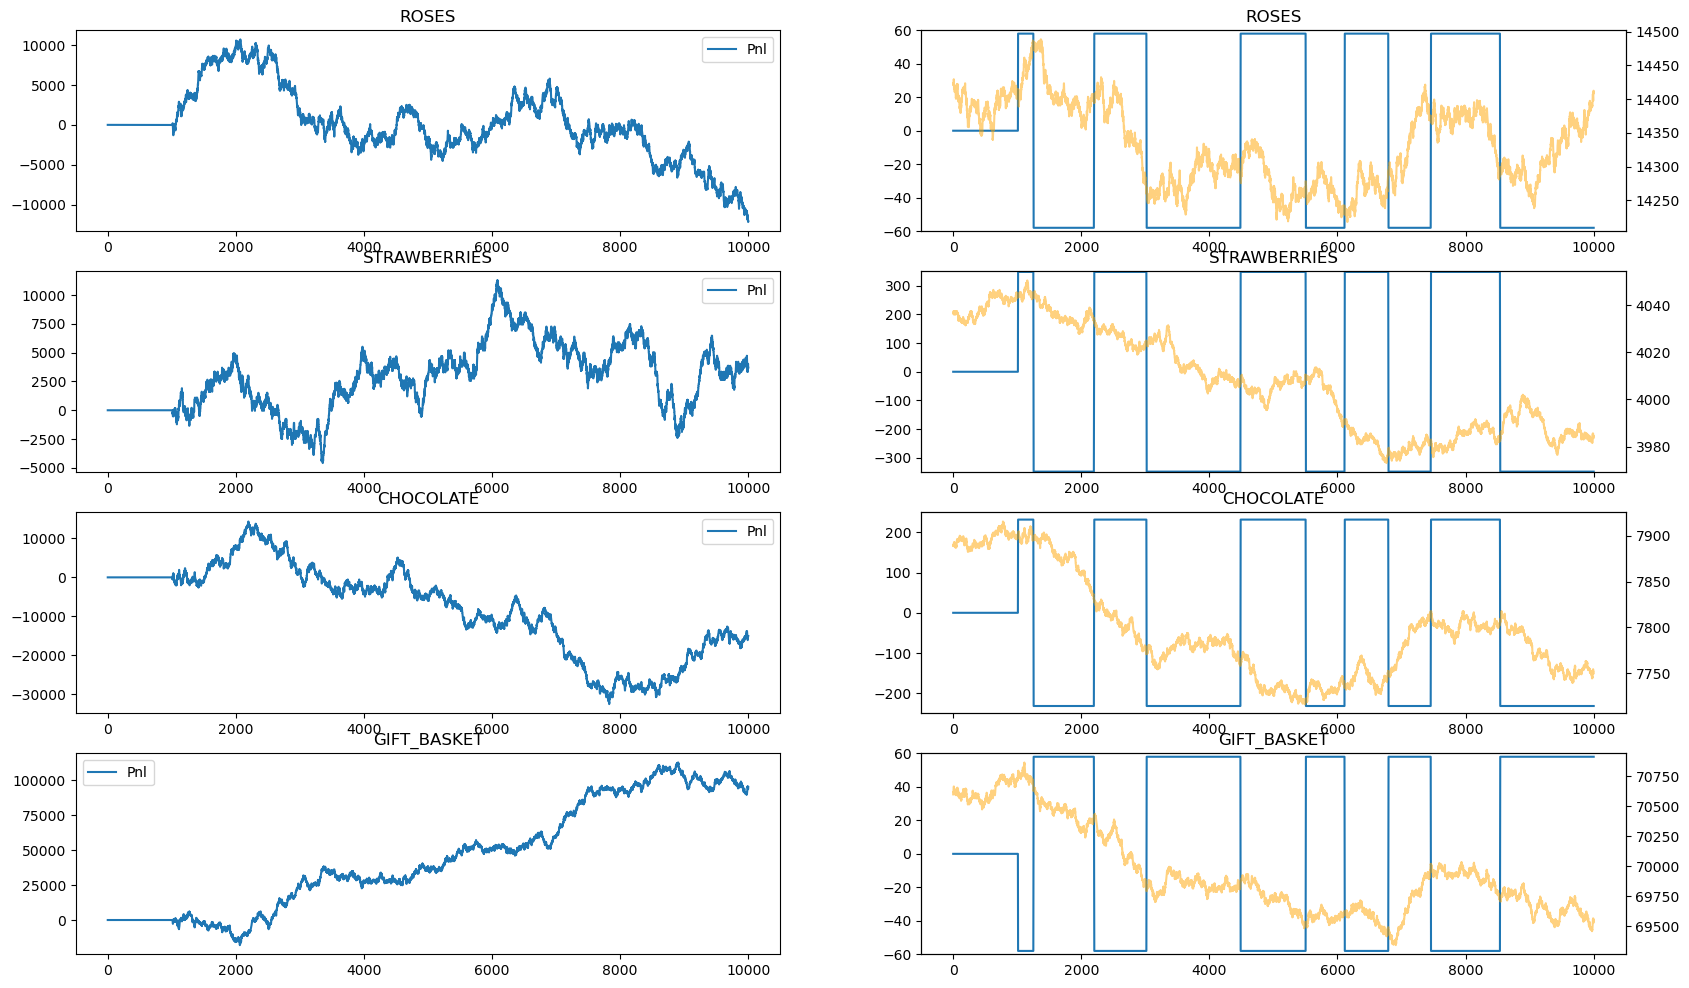

In [10]:
day = 2
# simulator = Simulator(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv")
df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round3/data/prices_round_3_day_{day}.csv", sep=';')
sim = simulator.Simulator(df=df)
trader1 = Trader()
res = sim.simulate(trader1)
res.summary(verbose=True)

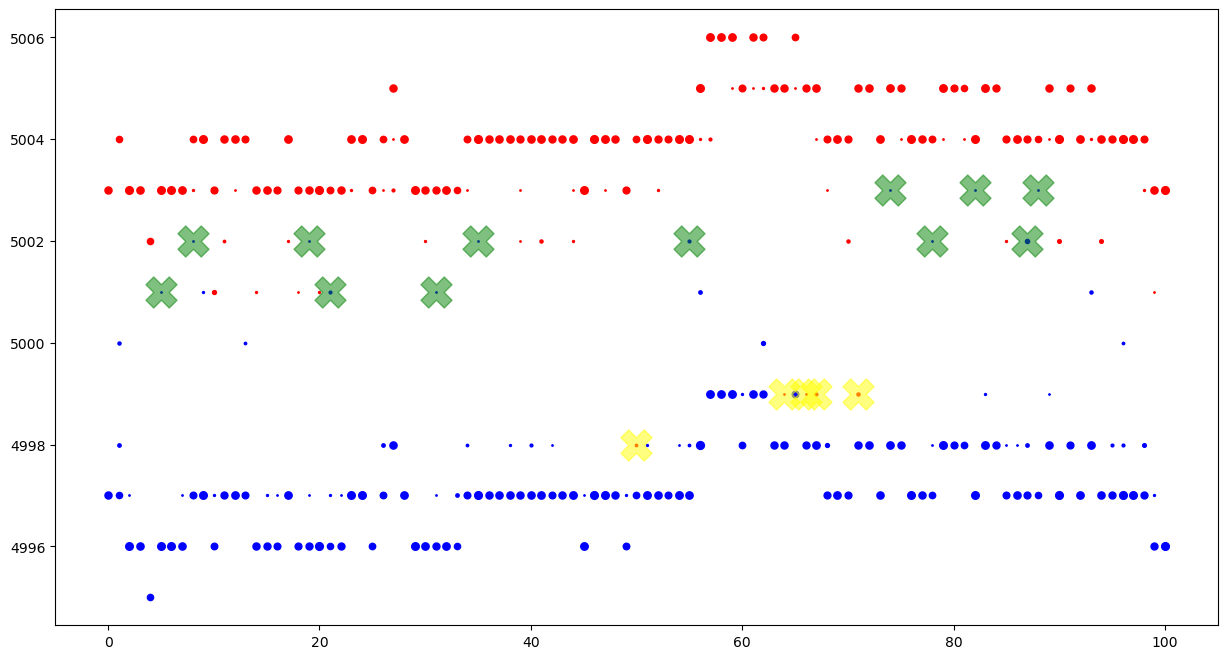

In [1023]:
M, N = 0, 100
product = "STARFRUIT"

fig, ax = plt.subplots(figsize=(15, 8))
for _, row in df[df['product'] == product].iterrows():
    idx = row['timestamp'] // 100
    if idx < M:
        continue
    if idx > N:
        break

    for i in (1, 2, 3):
        if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
            ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])

    for i in (1, 2, 3):
        if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
            ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])


for _, row in res.transactions[res.transactions['Product'] == product].iterrows():
    idx = row['TimeStamp'] // 100
    if idx < M:
        continue
    if idx > N:
        break
    if row['B/S'] == "B":
        ax.scatter(idx, row['Price'], c='yellow', marker='X', alpha=0.5, s=500)
    else:
        ax.scatter(idx, row['Price'], c='green', marker='X', alpha=0.5, s=500)

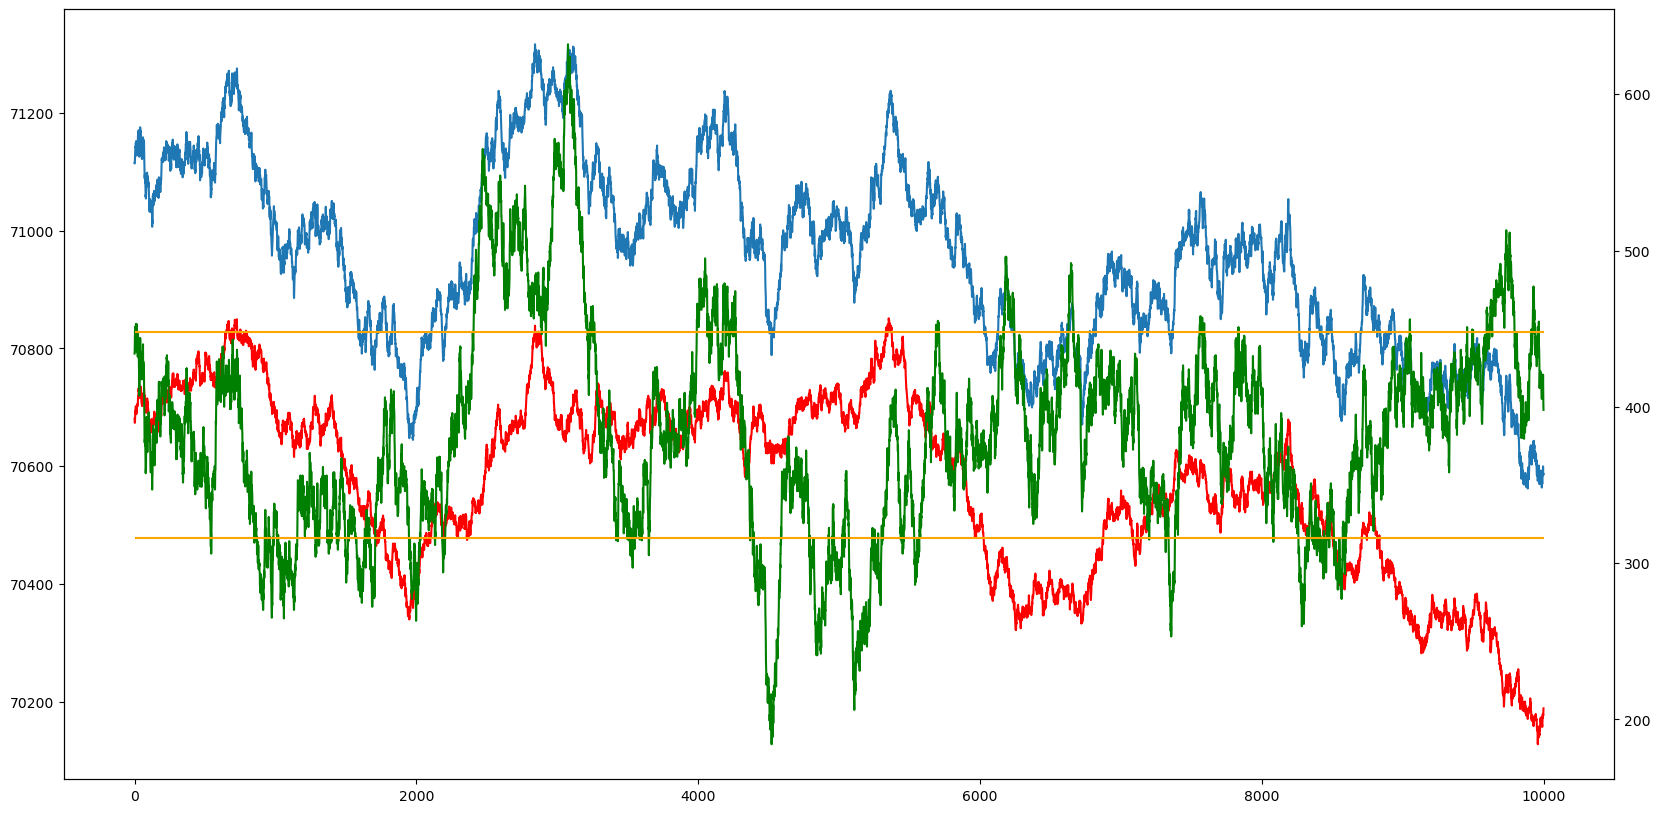

In [96]:
day = 1

df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round3/data/prices_round_3_day_{day}.csv", sep=';')
comb = df.loc[df['product'] == "STRAWBERRIES", 'mid_price'].values * 6 + \
       df.loc[df['product'] == "CHOCOLATE", 'mid_price'].values * 4 + \
       df.loc[df['product'] == "ROSES", 'mid_price'].values

fig, ax = plt.subplots(figsize=(20, 10))

ax2 = ax.twinx()

spread = df.loc[df['product'] == "GIFT_BASKET", 'mid_price'].values - comb
avg_spread = np.average(spread)


ax.plot(df.loc[df['product'] == "GIFT_BASKET", 'mid_price'].values)
ax.plot(comb, c='red')


ax2.plot(spread, c='green')

std = np.std(spread)
avg = np.average(spread)

ax2.hlines(avg + std, xmin=0, xmax=10000, color='orange')
ax2.hlines(avg - std, xmin=0, xmax=10000, color='orange')

In [97]:
np.average(spread)

381.9418

In [85]:
np.std(spread[:10000])

76.06878298025741

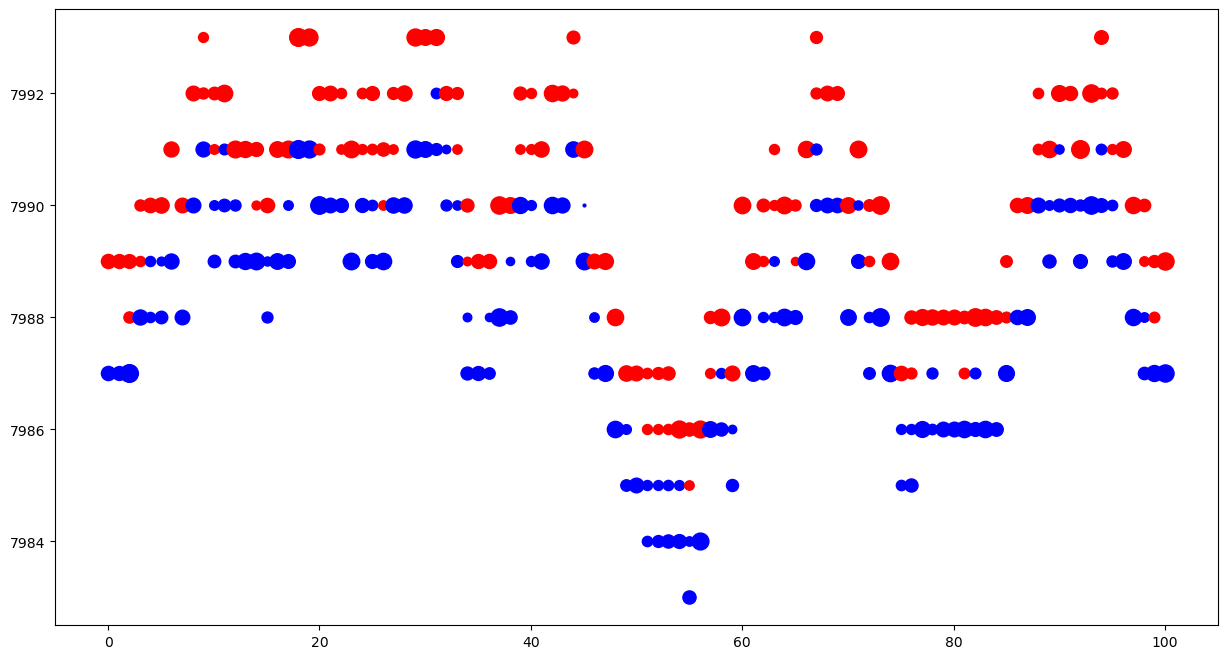

In [101]:
M, N = 0, 100
product = "CHOCOLATE"

fig, ax = plt.subplots(figsize=(15, 8))
for _, row in df[df['product'] == product].iterrows():
    idx = row['timestamp'] // 100
    if idx < M:
        continue
    if idx > N:
        break

    for i in (1, 2, 3):
        if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
            ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])

    for i in (1, 2, 3):
        if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
            ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])
